In [1]:
import numpy as np 
import gudhi
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist, squareform
from DensiTDA import landmarktools
from DensiTDA import alphatools 
from DensiTDA import graphtools 
from scipy.sparse.csgraph import minimum_spanning_tree
import numpy as np
from matplotlib import pylab as plt
from keras.datasets import mnist
from tqdm import tqdm
from collections import defaultdict
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px
from sklearn.metrics import mutual_info_score
from itertools import combinations

def merge(list1, list2):

    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    
    return merged_list

def MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Download MNIST Data

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [3]:
X = np.concatenate((train_X, test_X), axis=0)

In [4]:
label = np.concatenate((train_y, test_y), axis=0)

In [5]:
max_val = np.max(X)

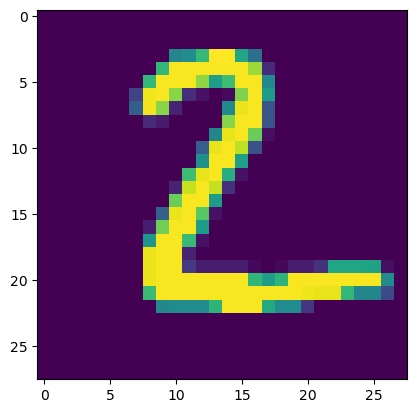

In [6]:
plt.imshow(X[60001])

# Organize Patches accross D-norm

In [7]:
total_images, len_x, len_y = X.shape

In [8]:
# extract unnormlized patches
patches_unnormalized = []
patch_radius = 2
patch_size = 2 * patch_radius + 1

with tqdm( total = total_images ) as pbar:
    for i in range(total_images): 
        for center_x in range(patch_radius, len_x - patch_radius):
            for center_y in range(patch_radius, len_y - patch_radius):
                patches_unnormalized.append(X[i,center_x - patch_radius:center_x + patch_radius + 1, center_y - patch_radius:center_y + patch_radius + 1] / max_val)
        pbar.update(n = 1)

100%|███████████████████████████████████| 70000/70000 [00:59<00:00, 1171.68it/s]


In [9]:
graph = defaultdict(list)

for i in range(patch_size):
    for j in range(patch_size): 
        if i != j or i == j: 
            if i == 0 and j == 0:
                graph[i * patch_size + j].append((i + 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + j + 1)
            elif i == patch_size - 1 and j == 0:
                graph[i * patch_size + j].append((i - 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + j + 1)
            elif i == 0 and j == patch_size - 1:
                graph[i * patch_size + j].append((i + 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + (j - 1))
            elif i == patch_size - 1 and j ==  patch_size - 1:
                graph[i * patch_size + j].append((i - 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + (j - 1))
            elif i == 0:
                graph[i * patch_size + j].append(i * patch_size + j - 1)
                graph[i * patch_size + j].append((i + 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + j + 1)
            elif j == 0:
                graph[i * patch_size + j].append((i + 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + j + 1)
                graph[i * patch_size + j].append((i - 1) * patch_size + j)
            elif i == patch_size - 1:
                graph[i * patch_size + j].append(i * patch_size + j - 1)
                graph[i * patch_size + j].append((i - 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + j + 1)
            elif j == patch_size - 1: 
                graph[i * patch_size + j].append((i + 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + j - 1)
                graph[i * patch_size + j].append((i - 1) * patch_size + j)
            else: 
                graph[i * patch_size + j].append(i * patch_size + j + 1)
                graph[i * patch_size + j].append((i + 1) * patch_size + j)
                graph[i * patch_size + j].append(i * patch_size + j - 1)
                graph[i * patch_size + j].append((i - 1) * patch_size + j)
    

In [10]:
D = np.zeros((patch_size ** 2, patch_size ** 2))

for i, edge_list in graph.items(): 
    D[i,i] = len(edge_list)
    for j in edge_list: 
        D[i,j] = -1

In [11]:
D

array([[ 2., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  3., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  3., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  3., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  3., -1.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0., -1.,  4., -1.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
      

Each patch is normalized in the following way: 

$$y = \frac{x - \frac{1}{9}\sum_{i = 1}^9 x_i}{\| x - \frac{1}{9}\sum_{i = 1}^9 x_i \|_D}$$

where

$$\| x \|_D = \sqrt{x^T D x}$$

which results in the set of patches $\subset \tilde{\mathbb S}^7$ where

$$\tilde{\mathbb S}^7 = \left \{ y \in \mathbb R^9 : \sum_{i = 1}^9 y_i = 0, y^T D y = 1 \right \}$$

In [12]:
# normalize patches
patches = []
contrast = []

with tqdm( total = len(patches_unnormalized) ) as pbar:
    for patch in patches_unnormalized: 
        remove_mean = patch - np.mean(patch)
        remove_mean = remove_mean.flatten()
        normed_val = np.sqrt(remove_mean.T @ D @ remove_mean)
    
        if np.linalg.norm(normed_val) > 0: # add a cutoff with a certain amount of intensity 
            patches.append(remove_mean / normed_val)
            contrast.append(normed_val)
        pbar.update(n = 1)

100%|███████████████████████████| 40320000/40320000 [06:17<00:00, 106796.54it/s]


In [13]:
intense_indices = np.argsort(contrast)[::-1]

In [14]:
patches[intense_indices[0]]

array([ 0.16156172, -0.10334465, -0.10334465,  0.16156172, -0.10334465,
        0.16156172, -0.03685834, -0.10334465,  0.16156172, -0.10334465,
        0.16156172, -0.10334465, -0.10334465,  0.16156172, -0.10334465,
        0.16156172, -0.10334465, -0.10334465,  0.16156172, -0.10334465,
        0.02962796, -0.10334465, -0.10334465,  0.16156172, -0.10334465])

In [15]:
contrast[intense_indices[0]]

3.7749187453540474

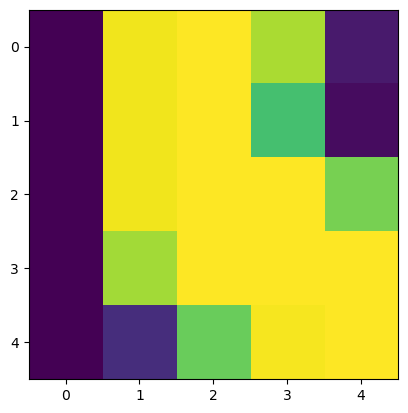

In [16]:
plt.imshow(patches[intense_indices[1000000]].reshape((patch_size,patch_size)))

In [17]:
y = patches[0]

In [18]:
np.sum(y)

-1.1102230246251565e-16

In [19]:
y.T @ D @ y

0.9999999999999998

In [20]:
basis = []
basis_val = []

for i in range(patch_size):
    for j in range(patch_size):
        vector = []
        for x in range(patch_size):
            for y in range(patch_size): 
                vector.append( np.cos( np.pi * i / patch_size * (x + 1/2) ) * np.cos( np.pi * j / patch_size * (y + 1/2) ) )
        vector = np.expand_dims(np.array(vector),axis=1)
        if np.sqrt(vector.T @ D @ vector) > 0:
            basis_val.append(np.sqrt(vector.T @ D @ vector))
            vector /= np.sqrt(vector.T @ D @ vector)
            basis.append(vector)
#A = np.array(basis).reshape(patch_size ** 2,patch_size ** 2 - 1)
A = np.squeeze(np.array(basis)).T

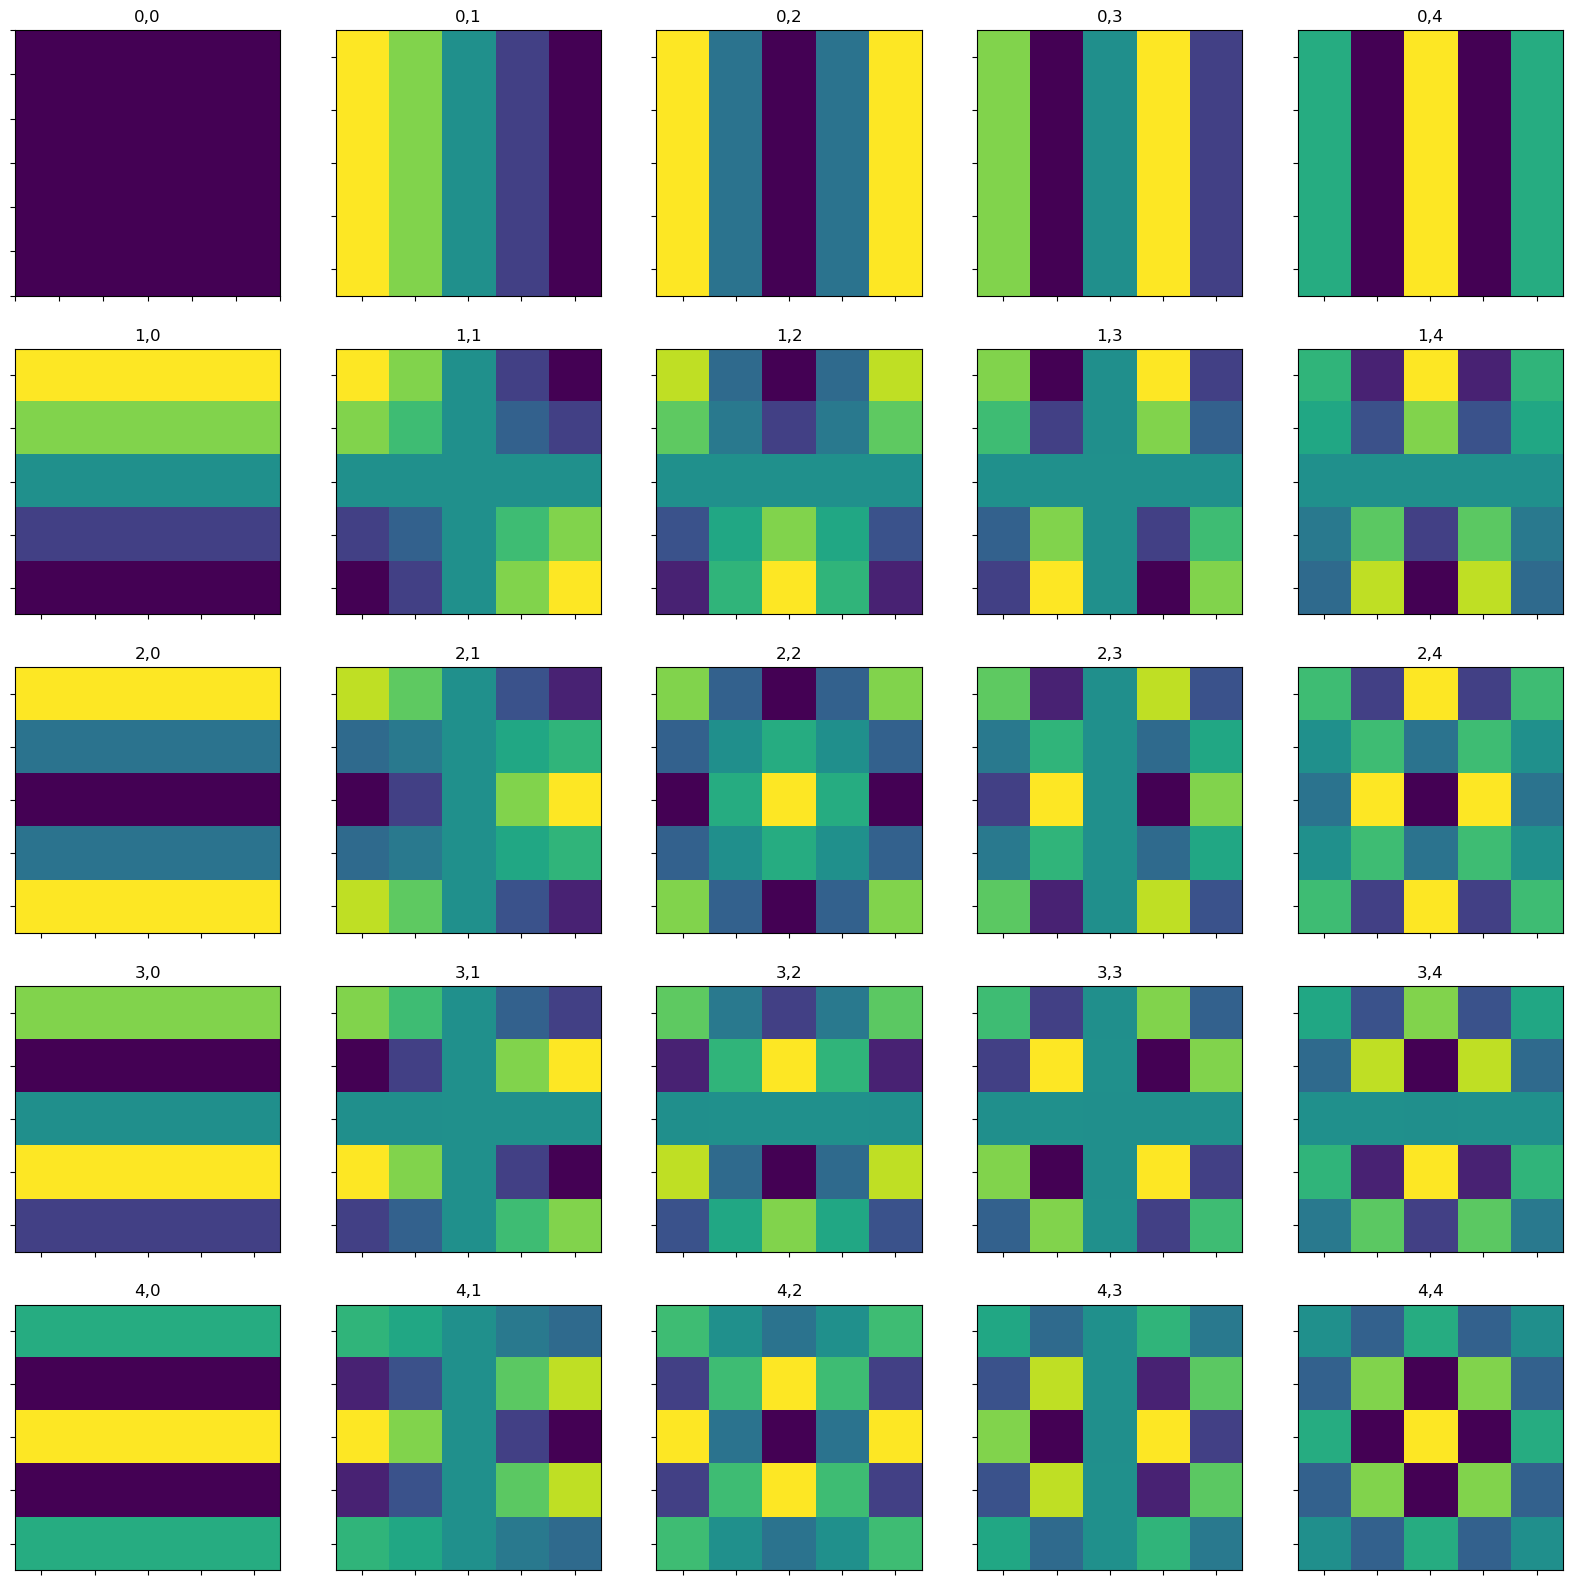

In [21]:
columns = patch_size
rows = patch_size
k = 0
fig, ax_array = plt.subplots(rows, columns, squeeze=False, figsize=(20,20))
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_title('{},{}'.format(i,j))
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        if not (i == 0 and j == 0):
            axes.imshow(A[:,i * patch_size + j - 1].reshape((patch_size,patch_size)))
        else: 
            axes.imshow(np.zeros((3,3)))
            
plt.show()

In [22]:
basis_sorted = np.argsort(np.array(basis_val).squeeze())

In [23]:
#basis

In [24]:
A.shape

(25, 24)

In [25]:
# # the non-constant DCT basis vectors 
# e_1 = np.expand_dims(np.array([1,0,-1,1,0,-1,1,0,-1],dtype='d'),axis=1)
# e_1 /= np.sqrt(e_1.T @ D @ e_1)
# e_2 = np.expand_dims(np.array([1,1,1,0,0,0,-1,-1,-1],dtype='d'),axis=1)
# e_2 /= np.sqrt(e_2.T @ D @ e_2)
# e_3 = np.expand_dims(np.array([1,-2,1,1,-2,1,1,-2,1],dtype='d'),axis=1)
# e_3 /= np.sqrt(e_3.T @ D @ e_3)
# e_4 = np.expand_dims(np.array([1,1,1,-2,-2,-2,1,1,1],dtype='d'),axis=1)
# e_4 /= np.sqrt(e_4.T @ D @ e_4)
# e_5 = np.expand_dims(np.array([1,0,-1,0,0,0,-1,0,1],dtype='d'),axis=1)
# e_5 /= np.sqrt(e_5.T @ D @ e_5)
# e_6 = np.expand_dims(np.array([1,0,-1,-2,0,2,1,0,-1],dtype='d'),axis=1)
# e_6 /= np.sqrt(e_6.T @ D @ e_6)
# e_7 = np.expand_dims(np.array([1,-2,1,0,0,0,-1,2,-1],dtype='d'),axis=1)
# e_7 /= np.sqrt(e_7.T @ D @ e_7)
# e_8 = np.expand_dims(np.array([1,-2,1,-2,4,-2,1,-2,1],dtype='d'),axis=1)
# e_8 /= np.sqrt(e_8.T @ D @ e_8)

In [26]:
#A = np.concatenate((e_1, e_2, e_3, e_4, e_5, e_6, e_7, e_8), axis = 1)

In [27]:
#Lambda = np.diag(np.reciprocal(np.square([np.linalg.norm(e_1), np.linalg.norm(e_2), np.linalg.norm(e_3), np.linalg.norm(e_4), np.linalg.norm(e_5), np.linalg.norm(e_6), np.linalg.norm(e_7), np.linalg.norm(e_8)])))

In [28]:
basis_vector_diagonalization = []
for col in range(len(basis)):
    basis_vector_diagonalization.append(np.reciprocal(np.square(np.linalg.norm(A[:,col]))))
Lambda = np.diag(basis_vector_diagonalization)

In [29]:
Lambda.shape

(24, 24)

In [30]:
B = Lambda @ A.T

Normalize to the euclidean sphere, by letting $A = [e_1, \ldots, e_8]$ and introduce 

$$\Lambda = diag \left (\frac{1}{\| e_1 \|^2}, \ldots, \frac{1}{\| e_8 \|^2} \right)$$

Then we will have unit vectors 

$$v = \Lambda A^T y \in \mathbb S^7$$

which will populate within $\mathbb S^7 = \{ v \in \mathbb R^8 : \sum_{i = 1}^8 v_i = 0, \| v \| = 1\}$

In [31]:
# normalize patches
patches_final = []

with tqdm( total = len(patches) ) as pbar:
    for y in patches: 
        patches_final.append(B @ y)
        pbar.update(n = 1)

100%|███████████████████████████| 23421560/23421560 [00:24<00:00, 962537.28it/s]


In [32]:
np.linalg.norm((patches_final[0]))

0.9999999999999994

In [33]:
Z = np.array(patches_final)

In [34]:
Z.shape

(23421560, 24)

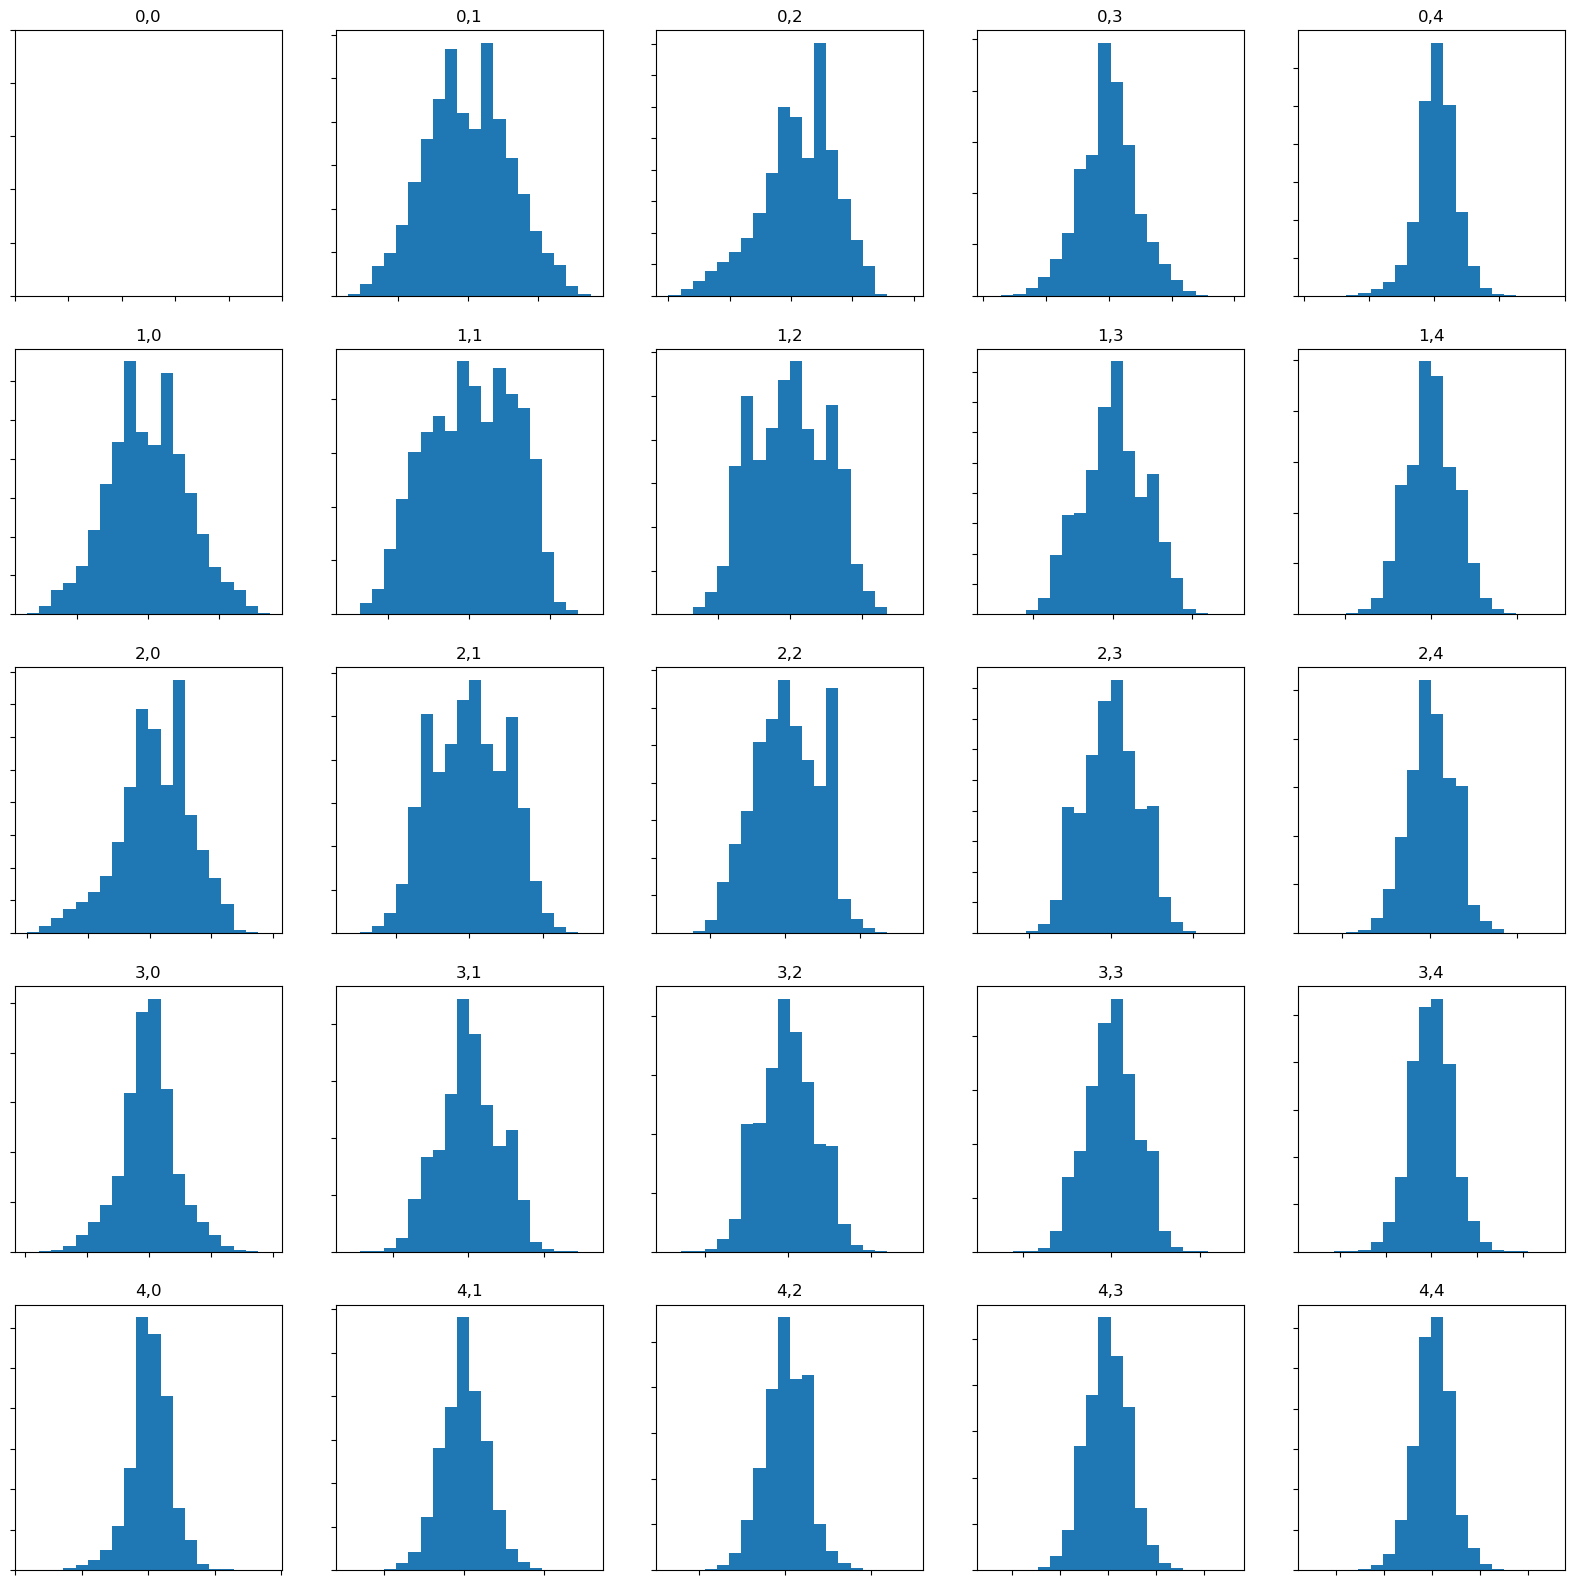

In [35]:
columns = patch_size
rows = patch_size
k = 0
fig, ax_array = plt.subplots(rows, columns, squeeze=False, figsize=(20,20))
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_title('{},{}'.format(i,j))
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        if not (i == 0 and j == 0):
            axes.hist(Z[:,i * patch_size + j - 1], bins=20)
        else: 
            continue
plt.show()

In [36]:
# for i in range(patch_size ** 2 - 1):
#     for j in range(patch_size ** 2 - 1): 
#         if i < j:
#             print(i,j,MI(Z[:,i], Z[:,j], bins = 20))

In [ ]:
alpha = 0.95
for k in range(1,5):
    max_basis = 0
    max_val = 0
    
    min_basis = 0
    min_val = len(Z)

    with tqdm( total = len(list(combinations(range(patch_size ** 2 - 1), k))) ) as pbar:

        for reduced_basis in list(combinations(range(patch_size ** 2 - 1), k)): 
            if len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > alpha]) > max_val:
                max_basis = reduced_basis
                max_val = len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > alpha])
            if len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > alpha]) < min_val:
                min_basis = reduced_basis
                min_val = len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > alpha])
            # print(reduced_basis, len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > alpha]))

            pbar.update(n = 1)

    print(max_basis, max_val)

100%|███████████████████████████████████████████| 24/24 [00:08<00:00,  2.72it/s]


(1,) 2352


100%|█████████████████████████████████████████| 276/276 [22:14<00:00,  4.84s/it]


(0, 1) 21898


100%|███████████████████████████████████████| 2024/2024 [31:11<00:00,  1.08it/s]


(0, 1, 2) 139366


  1%|▎                                     | 70/10626 [01:39<3:48:38,  1.30s/it]

In [ ]:
# for k in range(4,5):
#     max_basis = 0
#     max_val = 0
    
#     min_basis = 0
#     min_val = len(Z)
#     for reduced_basis in list(combinations(range(patch_size ** 2 - 1), k)): 
#         if len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > 0.9]) > max_val:
#             max_basis = reduced_basis
#             max_val = len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > 0.9])
#         if len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > 0.9]) < min_val:
#             min_basis = reduced_basis
#             min_val = len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > 0.9])
#         print(reduced_basis, len(Z[np.linalg.norm(Z[:,reduced_basis],axis=1) > 0.9]))

#     print(max_basis, max_val)

In [ ]:
# np.sum([np.linalg.norm(Z[:,(0,1,2,4,11,12)],axis=1) > 0.7])

In [ ]:
# max_basis = (3,32,43,54)

In [ ]:
max_points = [np.linalg.norm(Z[:,max_basis],axis=1) > alpha]
fuckups = 0
max_fucks = 100
with tqdm( total = len(list(combinations(range(patch_size ** 2 - 1), 4))) ) as pbar:
    
    for reduced_basis in list(combinations(range(patch_size ** 2 - 1), 4)):
        max_points = np.logical_or(max_points, [np.linalg.norm(Z[:,reduced_basis],axis=1) > alpha])
    
        if len([np.linalg.norm(Z[:,reduced_basis],axis=1) > alpha]) < max_fucks:
            if fuckups < max_fucks:
                fuckups += 1
            else: 
                break

        pbar.update(n = 1)

#max_points = 

In [ ]:
np.sum(max_points[0])

In [ ]:
Z_reduced = Z[max_points[0]]

In [ ]:
sizes = np.linalg.norm(Z_reduced[:,max_basis],axis=1)

In [ ]:
len(Z_reduced)

In [ ]:
N = 50000

In [ ]:
#indices_2 = np.argsort(contrast)[::-1]

In [ ]:
#indices_2[int(3 * indices_2.shape[0] / 10):int(9 * indices_2.shape[0] / 10)]

In [ ]:
# indices = np.random.choice(len(Z), N, replace=False)  
# Y = Z[indices, :]

In [ ]:
indices = np.random.choice(len(Z_reduced), N, replace=False)  
Y = Z_reduced[indices, :]

In [ ]:
Y.shape

In [ ]:
y_sizes = np.abs(sizes[indices])

In [ ]:
things_to_plot = []
k = 0
things_to_plot.append(
        go.Scatter3d(x=Y[:,max_basis[0 + k]], y=Y[:,max_basis[1 + k]], z=Y[:,max_basis[2 + k]],
            mode='markers',
            marker=dict(
                size=5 * y_sizes,
                color=Y[:,max_basis[3 + k]],                # set color to an array/list of desired values
                colorscale='viridis',   # choose a colorscale
                opacity=1
                ), 
            text=indices,
            hoverinfo='text',
            showlegend=False)
    )

layout = go.Layout(autosize=False, width=900, height=900, showlegend = False, scene=dict(
                 aspectmode='data'
         ))
fig = go.Figure(data = things_to_plot, layout = layout)
iplot(fig)

# Landmark on $\mathbb S^7$

In [ ]:
# hyperparameters
d = Y.shape[1]
h = np.std(Y) * (len(Y)) ** (-1 / (d + 4))
t = 1 / h ** 2
A = np.ones(len(Y)) / (h * len(Y))
s = 0.6

In [ ]:
# reduce_down = []
# for k in range(100):
#     N = 10000
#     indices = np.random.choice(Z.shape[0], N, replace=False)
#     Y = Z[indices[0:N], :]
chosen_landmarks, chosen_powers = landmarktools.optimal_spherical_landmarking(Y, A, t, s, 90, batch_size = 1000)
# reduce_down += chosen_landmarks

In [ ]:
print("Precentage of points selected: ", 100 * len(chosen_landmarks) / len(X))

In [ ]:
Q = np.array(chosen_landmarks)

In [ ]:
things_to_plot = []

things_to_plot.append(
        go.Scatter3d(x=Q[:,max_basis[0]], y=Q[:,max_basis[1]], z=Q[:,max_basis[2]],
            mode='markers',
            marker=dict(
                size=5,
                color=Q[:,max_basis[3]],                # set color to an array/list of desired values
                colorscale='viridis',   # choose a colorscale
                opacity=1
                ), 
            text=indices,
            hoverinfo='text',
            showlegend=False)
    )

layout = go.Layout(autosize=False, width=900, height=900, showlegend = False, scene=dict(
                 aspectmode='data'
         ))
fig = go.Figure(data = things_to_plot, layout = layout)
iplot(fig)

# Identify Average Distance

In [ ]:
# distance_distribution = squareform(pdist(chosen_landmarks))

In [ ]:
# distances = minimum_spanning_tree(distance_distribution)

In [ ]:
# alpha = np.max(np.max(distances, axis=1))

In [ ]:
alpha = np.sqrt(2 - 2 * s ** (1/t))

In [ ]:
#alpha *= 2

In [ ]:
#alpha /= 2

In [ ]:
#alpha = 0.3

# Construct Alpha Complex on Landmarked Points

In [ ]:
S = np.array(chosen_landmarks)

In [ ]:
P = np.zeros(len(chosen_landmarks))
D = 3

In [ ]:
my_alpha_complex = alphatools.compute_alpha_complex(S, P, alpha, D)

In [ ]:
filtration = []
for d in range(D + 1):
    filtration += my_alpha_complex[d]

In [ ]:
example2 = gudhi.SimplexTree()
for d in range(D + 1):
    for facet, val in my_alpha_complex[d]:
        example2.insert(facet, filtration=val)
        
my_persistence = example2.persistence(homology_coeff_field = 2)

In [ ]:
gudhi.plot_persistence_diagram(my_persistence, legend=True)
plt.show()

In [ ]:
betti_numbers = {}
for i in range(D):
    betti_numbers[i] = 0
for bar, bd in my_persistence:
    if bd[1] > 10000: 
        betti_numbers[bar] += 1

print("Betti Numbers up to Dimension 3 over the field F_2")
betti_numbers

In [ ]:
my_persistence = example2.persistence(homology_coeff_field = 3)

In [ ]:
gudhi.plot_persistence_diagram(my_persistence, legend=True)
plt.show()

In [ ]:
betti_numbers = {}
for i in range(D):
    betti_numbers[i] = 0
for bar, bd in my_persistence:
    if bd[1] > 10000: 
        betti_numbers[bar] += 1

print("Betti Numbers up to Dimension 3 over the field F_3")
betti_numbers

In [ ]:
graphtools.draw_abstract_simplcial_complex(my_alpha_complex)

In [ ]:
# if you adjust to the bigger patches of 10x10, then you end up with a mobius strip as a fiber within the klein bottle. 

In [ ]:
# # D-matrix for normalization
# D = np.array([[2,-1,0,-1,0,0,0,0,0],
#      [-1,3,-1,0,-1,0,0,0,0],
#      [0,-1,2,0,0,-1,0,0,0],
#      [-1,0,0,3,-1,0,-1,0,0],
#      [0,-1,0,-1,4,-1,0,-1,0],
#      [0,0,-1,0,-1,3,0,0,-1],
#      [0,0,0,-1,0,0,2,-1,0],
#      [0,0,0,0,-1,0,-1,3,-1],
#      [0,0,0,0,0,-1,0,-1,2]])